In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
database=input_data.read_data_sets('/content/data',one_hot=True)

#parameter 
alpha = 0.001
epochs = 100001
batch_size = 32

#network parameter
image_dimension = 784
hidden_layer_dimension = 512

#latent_variable
latent_variable_dimension = 2

#Initialization of weight matrix
def xavier(in_shape):
  val = tf.random_normal(shape=in_shape,stddev= 1./tf.sqrt(in_shape[0]/2.))
  return(val)  

#weight and bais dictionaries

Weight = {
    "encoder_hidden": tf.Variable(xavier([image_dimension,hidden_layer_dimension])),
    "mean_layer": tf.Variable(xavier([hidden_layer_dimension,latent_variable_dimension])),
    "std_layer": tf.Variable(xavier([hidden_layer_dimension,latent_variable_dimension])),
    "decoder_hidden":tf.Variable(xavier([latent_variable_dimension,hidden_layer_dimension])),
    "weight_decoder":tf.Variable(xavier([hidden_layer_dimension,image_dimension]))
}

Bias = {
    "b_encoder_hidden": tf.Variable(xavier([hidden_layer_dimension])),
    "b_mean_layer": tf.Variable(xavier([latent_variable_dimension])),
    "b_std_layer": tf.Variable(xavier([latent_variable_dimension])),
    "b_decoder_hidden":tf.Variable(xavier([hidden_layer_dimension])),
    "b_weight_decoder":tf.Variable(xavier([image_dimension]))
}

def loss_function(orig_img,reconst_img):
  
  #Reconstuction Loss
  data_fidelity_loss= orig_img*tf.log(1e-10 + reconst_img)+ (1 - orig_img)*tf.log(1e-10+1-reconst_img)
  data_fidelity_loss= -tf.reduce_sum(data_fidelity_loss,1)
  
  #KL Divergence loss
  KL_div_loss = 1 + std_layer - tf.square(mean_layer) -tf.exp(std_layer)
  KL_div_loss = -0.5 * tf.reduce_sum(KL_div_loss,1)

  network_loss = tf.reduce_mean(data_fidelity_loss +KL_div_loss)
  return network_loss

Extracting /content/data/train-images-idx3-ubyte.gz
Extracting /content/data/train-labels-idx1-ubyte.gz
Extracting /content/data/t10k-images-idx3-ubyte.gz
Extracting /content/data/t10k-labels-idx1-ubyte.gz


# NORMAL

In [0]:
#building the VAE

#Encoder Section
image_X  = tf.placeholder(tf.float32, shape = [None,image_dimension])
Encoder_layer = tf.add(tf.matmul(image_X,Weight["encoder_hidden"]),Bias["b_encoder_hidden"])
Encoder_layer = tf.nn.tanh(Encoder_layer)

mean_layer = tf.add(tf.matmul(Encoder_layer,Weight["mean_layer"]),Bias["b_mean_layer"])
std_layer = tf.add(tf.matmul(Encoder_layer,Weight["std_layer"]),Bias["b_std_layer"])

#Reparametrization trick

epsilon = tf.random_normal(tf.shape(std_layer),dtype = tf.float32,mean = 0.0, stddev = 1.0)
latent_layer = mean_layer + tf.exp(0.5*std_layer)*epsilon


#Decoder Section

Decoder_hidden = tf.add(tf.matmul(latent_layer,Weight["decoder_hidden"]),Bias["b_decoder_hidden"])
Decoder_hidden = tf.nn.tanh(Decoder_hidden)

Decoder_output = tf.add(tf.matmul(Decoder_hidden,Weight["weight_decoder"]),Bias["b_weight_decoder"])
Decoder_output = tf.nn.sigmoid(Decoder_output)

loss_value = loss_function(image_X,Decoder_output)
optimizer = tf.train.AdamOptimizer(alpha).minimize(loss_value) 
init = tf.global_variables_initializer()

In [0]:
#Executing the computational graph

#start session

sess=tf.Session()

#run session
sess.run(init)

for i in range(epochs):
  x_batch,_ = database.train.next_batch(batch_size)
  _,loss = sess.run([optimizer,loss_value] ,feed_dict = {image_X: x_batch})
  
  if i%5000 == 0:
    print("Loss is {0} at iteration {1}".format(loss,i))

Loss is 667.444580078125 at iteration 0
Loss is 166.5573272705078 at iteration 5000
Loss is 154.4144287109375 at iteration 10000
Loss is 154.116455078125 at iteration 15000
Loss is 149.17205810546875 at iteration 20000
Loss is 166.25888061523438 at iteration 25000
Loss is 133.54388427734375 at iteration 30000
Loss is 156.52545166015625 at iteration 35000
Loss is 152.457275390625 at iteration 40000
Loss is 168.0529327392578 at iteration 45000
Loss is 147.62779235839844 at iteration 50000
Loss is 146.15049743652344 at iteration 55000
Loss is 148.09091186523438 at iteration 60000
Loss is 153.84603881835938 at iteration 65000
Loss is 137.6515350341797 at iteration 70000
Loss is 133.76260375976562 at iteration 75000
Loss is 147.07394409179688 at iteration 80000
Loss is 147.96994018554688 at iteration 85000
Loss is 133.33909606933594 at iteration 90000
Loss is 138.8763885498047 at iteration 95000
Loss is 138.37904357910156 at iteration 100000


In [0]:
#Testing phase

#Noise input handle 
noise_X  = tf.placeholder(tf.float32, shape = [None,latent_variable_dimension])

#Rebuild the decoder to create outputimage from noise

#Decoder Section(Repeat)

Decoder_hidden = tf.add(tf.matmul(noise_X,Weight["decoder_hidden"]),Bias["b_decoder_hidden"])
Decoder_hidden = tf.nn.tanh(Decoder_hidden)

Decoder_output = tf.add(tf.matmul(Decoder_hidden,Weight["weight_decoder"]),Bias["b_weight_decoder"])
Decoder_output = tf.nn.sigmoid(Decoder_output)

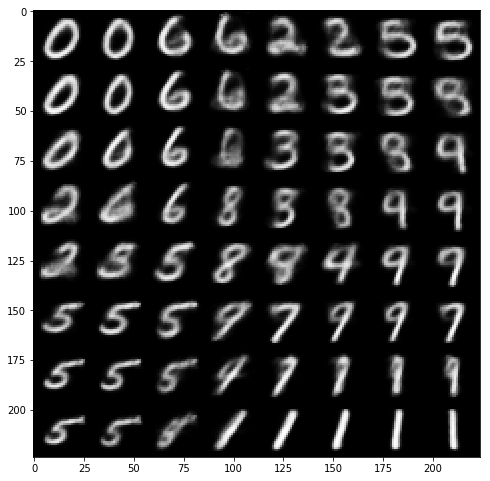

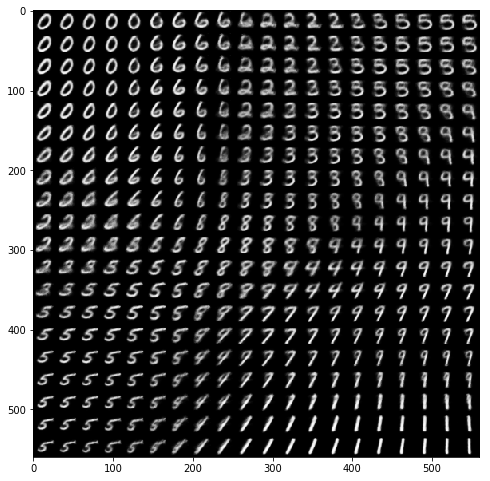

In [0]:
#output visualization

n =8
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(-2,2,n)

empty_image = np.empty((28*n,28*n))
for i,zi in enumerate(x_limit):
  for j,pi in enumerate(y_limit):
    generated_latent_layer=np.array([[zi,pi]]*batch_size)
    generated_image=sess.run(Decoder_output,feed_dict={noise_X:generated_latent_layer})
    empty_image[(n-i-1)*28:(n-i)*28,j*28:(j+1)*28]=generated_image[0].reshape(28,28)
plt.figure(figsize=(8,10))

X,Y=np.meshgrid(x_limit,y_limit)
plt.imshow(empty_image,origin="upper",cmap="gray")
plt.grid(False)
plt.show()





#output visualization

n =20
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(-2,2,n)
# print(x_limit)
# print(y_limit)
empty_image = np.empty((28*n,28*n))
for i,zi in enumerate(x_limit):
  for j,pi in enumerate(y_limit):
    generated_latent_layer=np.array([[zi,pi]]*batch_size)
    generated_image=sess.run(Decoder_output,feed_dict={noise_X:generated_latent_layer})
    empty_image[(n-i-1)*28:(n-i)*28,j*28:(j+1)*28]=generated_image[0].reshape(28,28)
plt.figure(figsize=(8,10))

X,Y=np.meshgrid(x_limit,y_limit)
plt.imshow(empty_image,origin="upper",cmap="gray")
plt.grid(False)
plt.show()
sess.close()

# UNIFORM

In [0]:
#building the VAE

#Encoder Section
image_X  = tf.placeholder(tf.float32, shape = [None,image_dimension])
Encoder_layer = tf.add(tf.matmul(image_X,Weight["encoder_hidden"]),Bias["b_encoder_hidden"])
Encoder_layer = tf.nn.tanh(Encoder_layer)

mean_layer = tf.add(tf.matmul(Encoder_layer,Weight["mean_layer"]),Bias["b_mean_layer"])
std_layer = tf.add(tf.matmul(Encoder_layer,Weight["std_layer"]),Bias["b_std_layer"])

#Reparametrization trick

epsilon = tf.random_uniform(tf.shape(std_layer),dtype = tf.float32,minval=0,maxval=1)

latent_layer = mean_layer + tf.exp(0.5*std_layer)*epsilon


#Decoder Section

Decoder_hidden = tf.add(tf.matmul(latent_layer,Weight["decoder_hidden"]),Bias["b_decoder_hidden"])
Decoder_hidden = tf.nn.tanh(Decoder_hidden)

Decoder_output = tf.add(tf.matmul(Decoder_hidden,Weight["weight_decoder"]),Bias["b_weight_decoder"])
Decoder_output = tf.nn.sigmoid(Decoder_output)

loss_value = loss_function(image_X,Decoder_output)
optimizer = tf.train.AdamOptimizer(alpha).minimize(loss_value)
 
init = tf.global_variables_initializer()

In [0]:
#Executing the computational graph

#start session

sess=tf.Session()

#run session
sess.run(init)

for i in range(epochs):
  x_batch,_ = database.train.next_batch(batch_size)
  _,loss = sess.run([optimizer,loss_value] ,feed_dict = {image_X: x_batch})
  
  if i%5000 == 0:
    print("Loss is {0} at iteration {1}".format(loss,i))

Loss is 601.4661865234375 at iteration 0
Loss is 153.87388610839844 at iteration 5000
Loss is 163.3795166015625 at iteration 10000
Loss is 154.67910766601562 at iteration 15000
Loss is 148.53929138183594 at iteration 20000
Loss is 130.00881958007812 at iteration 25000
Loss is 127.70489501953125 at iteration 30000
Loss is 156.05186462402344 at iteration 35000
Loss is 127.081298828125 at iteration 40000
Loss is 150.8707275390625 at iteration 45000
Loss is 137.96444702148438 at iteration 50000
Loss is 138.59262084960938 at iteration 55000
Loss is 151.8458251953125 at iteration 60000
Loss is 137.733154296875 at iteration 65000
Loss is 145.302734375 at iteration 70000
Loss is 131.93133544921875 at iteration 75000
Loss is 138.18240356445312 at iteration 80000
Loss is 135.0955352783203 at iteration 85000
Loss is 137.83816528320312 at iteration 90000
Loss is 138.78900146484375 at iteration 95000
Loss is 135.19798278808594 at iteration 100000


In [0]:
#Testing phase

#Noise input handle 
noise_X  = tf.placeholder(tf.float32, shape = [None,latent_variable_dimension])

#Rebuild the decoder to create outputimage from noise

#Decoder Section(Repeat)

Decoder_hidden = tf.add(tf.matmul(noise_X,Weight["decoder_hidden"]),Bias["b_decoder_hidden"])
Decoder_hidden = tf.nn.tanh(Decoder_hidden)

Decoder_output = tf.add(tf.matmul(Decoder_hidden,Weight["weight_decoder"]),Bias["b_weight_decoder"])
Decoder_output = tf.nn.sigmoid(Decoder_output)

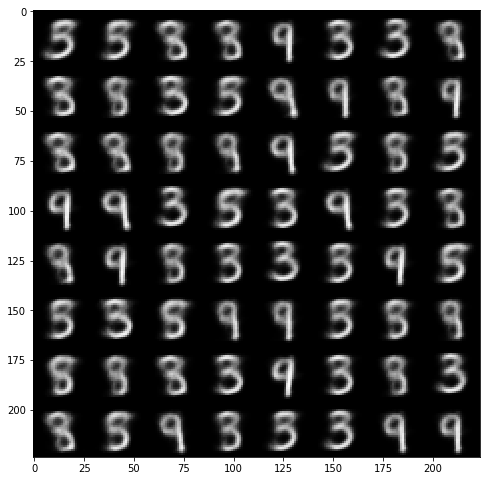

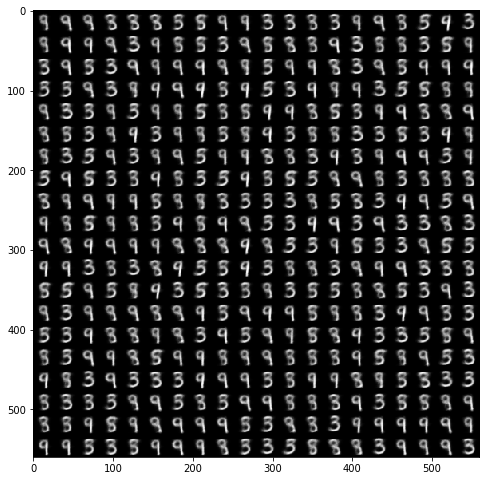

In [0]:
#output visualization

n =8
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(-2,2,n)
# print(x_limit)
# print(y_limit)
empty_image = np.empty((28*n,28*n))
for i,zi in enumerate(x_limit):
  for j,pi in enumerate(y_limit):
    generated_latent_layer = np.random.uniform(size=[batch_size,latent_variable_dimension])
    generated_image=sess.run(Decoder_output,feed_dict={noise_X:generated_latent_layer})
    empty_image[(n-i-1)*28:(n-i)*28,j*28:(j+1)*28]=generated_image[0].reshape(28,28)
plt.figure(figsize=(8,10))

X,Y=np.meshgrid(x_limit,y_limit)
plt.imshow(empty_image,origin="upper",cmap="gray")
plt.grid(False)
plt.show()




n =20
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(-2,2,n)
# print(x_limit)
# print(y_limit)
empty_image = np.empty((28*n,28*n))
for i,zi in enumerate(x_limit):
  for j,pi in enumerate(y_limit):
    generated_latent_layer = np.random.uniform(size=[batch_size,latent_variable_dimension])
    generated_image=sess.run(Decoder_output,feed_dict={noise_X:generated_latent_layer})
    empty_image[(n-i-1)*28:(n-i)*28,j*28:(j+1)*28]=generated_image[0].reshape(28,28)
plt.figure(figsize=(8,10))

X,Y=np.meshgrid(x_limit,y_limit)
plt.imshow(empty_image,origin="upper",cmap="gray")
plt.grid(False)
plt.show()
sess.close()